
## CycleGAN Brief

CycleGAN is unpaired image-to-image translation task from $A$ to $B$ and represented by two generative networks $G$ and $F$:
$$
\hat{y} = G(x) \in B,\text{ for } x \in A \\
\hat{x} = F(y) \in A,\text{ for } y \in B
$$

and two discriminators $D_A$ and $D_B$. Training of the networks is done by minimizing the loss is a sum of 3 components:
$$
\mathcal{L}(G, F, D_A, D_B) = \mathcal{L}_{GAN}(G, D_B) + \mathcal{L}_{GAN}(F, D_A) + \lambda \mathcal{L}_{cyc}(G, F)
$$
with GAN loss:
$$
\mathcal{L}_{GAN}(G, D_B) = \text{mean}_{x \in A}\left[ (D_B(G(x)) - 1)^2 \right]+ \text{mean}_{y \in B}\left[ (D_B(y) - 1)^2 \right] \\
\mathcal{L}_{GAN}(F, D_A) = \text{mean}_{y \in B}\left[ (D_A(F(y)) - 1)^2 \right]+ \text{mean}_{x \in A}\left[ (D_A(x) - 1)^2 \right]
$$
and forward and backward cycle consistency term:
$$
\mathcal{L}_{cyc}(G, F) = \text{mean}_{x \in A}\left[ |F(G(x)) - x|_1 \right] + \text{mean}_{y \in B}\left[ |G(F(y)) - y|_1 \right]
$$



## check for GPU's

In [ ]:
!nvidia-smi


## Requirements


 We install of pytorch-ignite

In [56]:
# !pip install --pre pytorch-ignite

In [2]:
import torch
import ignite
torch.__version__, ignite.__version__

('1.11.0', '0.4.8')

In [3]:
import random
import torch

seed = 17
random.seed(seed)
_ = torch.manual_seed(seed)

## Dataflow
Dataset setup 
The data set consits of about samples as below
Train A: 
Train B:
Test A:
Test B :

Here we are using 2 diffrent file loaders to accomodata *png and *jpg images seperately


In [4]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class FilesDataset(Dataset):
    
    def __init__(self, path, extension="*.png"):
        self.path = Path(path)
        assert self.path.exists(), "Path '{}' is not found".format(path)
        self.images = list(self.path.rglob(extension))
        assert len(self.images) > 0, "No images with extension {} found at '{}'".format(extension, path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return Image.open(self.images[i]).convert('RGB')


class FilesDataset2(Dataset):
    
    def __init__(self, path, extension="*.jpg"):
        self.path = Path(path)
        assert self.path.exists(), "Path '{}' is not found".format(path)
        self.images = list(self.path.rglob(extension))
        assert len(self.images) > 0, "No images with extension {} found at '{}'".format(extension, path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return Image.open(self.images[i]).convert('RGB')        

In [5]:
from pathlib import Path

root = Path("./pizza")

train_A = FilesDataset('/common/home/vs734/task_4/TrainImages')
train_B = FilesDataset2(root / "trainB")

test_A = FilesDataset("/common/home/vs734/task_4/TestImages") 
test_B = FilesDataset2(root / "testB")

Some details on the datasets:

In [61]:
print("Dataset sizes: \ntrain A: {} | B: {}\ntest A: {} | B: {}\n\t".format(len(train_A), len(train_B), len(test_A), len(test_B)))

Dataset sizes: 
train A: 13354 | B: 6688
test A: 1554 | B: 836
	


In [62]:
print("Train random image sizes (A): {}, {}, {}, {}".format(train_A[0].size, train_A[1].size, train_A[10].size, train_A[-1].size))

Train random image sizes (A): (512, 512), (512, 512), (512, 512), (512, 512)


In [63]:
print("Train random image sizes (B): {}, {}, {}, {}".format(train_B[0].size, train_B[1].size, train_B[10].size, train_B[-1].size))

Train random image sizes (B): (1080, 1182), (577, 577), (652, 652), (1080, 1080)


In [27]:
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Train dataset 'Real Pizza'")
plt.imshow(train_A[10])
plt.subplot(122)
plt.title("Train dataset 'Synthetic Pizza'")
plt.imshow(train_B[10])

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Test dataset 'Real Pizza'")
plt.imshow(test_A[0])
plt.subplot(122)
plt.title("Test dataset 'Synthetic Pizza'")
plt.imshow(test_B[0])

Here we create a dataset composed of random image pairs of datasets A and B

In [6]:
import random


class Image2ImageDataset(Dataset):
    
    def __init__(self, ds_a, ds_b):
        self.dataset_a = ds_a
        self.dataset_b = ds_b
    
    def __len__(self):
        return max(len(self.dataset_a), len(self.dataset_b))

    def __getitem__(self, i):
        dp_a = self.dataset_a[i % len(self.dataset_a)]
        j = random.randint(0, len(self.dataset_b) - 1)
        dp_b = self.dataset_b[j]
        return {
            'A': dp_a,
            'B': dp_b
        }


class TransformedDataset(Dataset):
        
    def __init__(self, ds, transform):
        self.dataset = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return {k: self.transform(v) for k, v in self.dataset[i].items()}

In [23]:
train_ab_ds = Image2ImageDataset(train_A, train_B)
test_ab_ds = Image2ImageDataset(test_A, test_B)

In [ ]:
dp = train_ab_ds[20]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Train dataset 'Pizza'")
plt.imshow(dp['A'])
plt.subplot(122)
plt.title("Train dataset 'Synthetic'")
plt.imshow(dp['B'])

In [ ]:
dp = test_ab_ds[20]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Test dataset 'Real Pizza'")
plt.imshow(dp['A'])
plt.subplot(122)
plt.title("Test dataset 'Synthetic Pizza'")
plt.imshow(dp['B'])

In [25]:
from torchvision.transforms import Compose, ColorJitter, RandomHorizontalFlip, ToTensor, Normalize, RandomCrop,Resize

# here we are resizing to scale images which are not of size 256*256 to accomodate them 
train_transform = Compose([
    Resize(256),                 
    RandomCrop(256),
    RandomHorizontalFlip(),
    ColorJitter(),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
transformed_train_ab_ds = TransformedDataset(train_ab_ds, transform=train_transform)


batch_size = 10
train_ab_loader = DataLoader(transformed_train_ab_ds, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)


test_transform = Compose([
    Resize(256),
    RandomCrop(256),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
transformed_test_ab_ds = TransformedDataset(test_ab_ds, transform=test_transform)
batch_size = 10
test_ab_loader = DataLoader(transformed_test_ab_ds, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

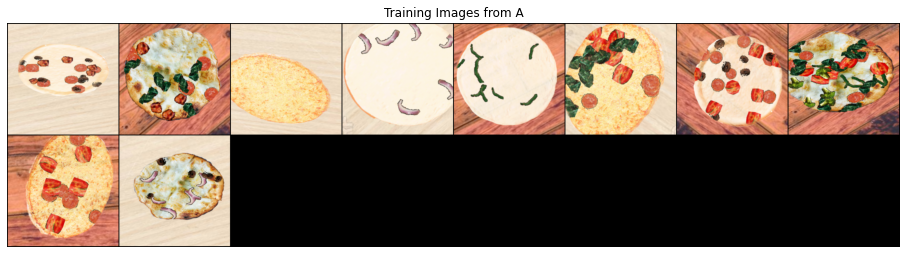

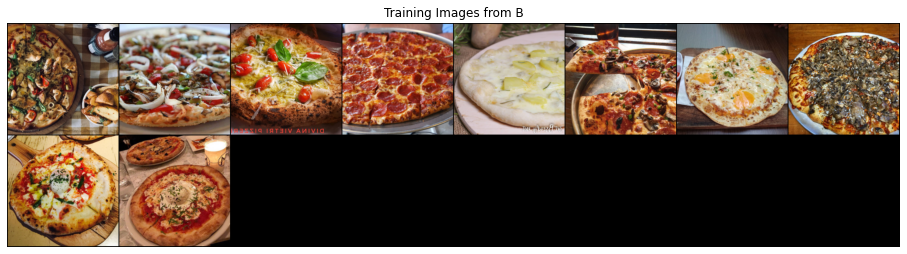

In [72]:
import torchvision.utils as vutils

# Plot some training images
real_batch = next(iter(train_ab_loader))

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images from A")
plt.imshow( 
    vutils.make_grid(real_batch['A'][:64], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images from B")
plt.imshow(
    vutils.make_grid(real_batch['B'][:64], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)
real_batch = None
torch.cuda.empty_cache()

## Generator and Discriminator networks

- Generator network architecture contains 9 residual blocks

Using paper's notations:
```
c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3,tanh
```
where `c7s1-k` denotes a 7x7 Convolution-InstanceNorm-ReLU layer with `k` filters and stride 1. `dk` denotes a 3x3 Convolution-InstanceNorm-ReLU layer  with `k` filters and stride 2. Reflection padding was used to reduce artifacts. `Rk` denotes a residual block that contains two 3x3 convolutional layers with the same number of filters on both layer. `uk` denotes a 3x3 fractional-strided-Convolution-InstanceNorm-ReLU layer with `k` filters and stride 1/2.

In [9]:
import torch
import torch.nn as nn


def get_conv_inorm_relu(in_planes, out_planes, kernel_size, stride, reflection_pad=True, with_relu=True):
    layers = []
    padding = (kernel_size - 1) // 2
    if reflection_pad:
        layers.append(nn.ReflectionPad2d(padding=padding))
        padding = 0
    layers += [
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
    ]
    if with_relu:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)


def get_conv_transposed_inorm_relu(in_planes, out_planes, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True)
    )


class ResidualBlock(nn.Module):
    
    def __init__(self, in_planes):
        super(ResidualBlock, self).__init__()
        self.conv1 = get_conv_inorm_relu(in_planes, in_planes, kernel_size=3, stride=1)
        self.conv2 = get_conv_inorm_relu(in_planes, in_planes, kernel_size=3, stride=1, with_relu=False)        

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)        
        return x + residual


class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.c7s1_64 = get_conv_inorm_relu(3, 64, kernel_size=7, stride=1)
        self.d128 = get_conv_inorm_relu(64, 128, kernel_size=3, stride=2, reflection_pad=False)
        self.d256 = get_conv_inorm_relu(128, 256, kernel_size=3, stride=2, reflection_pad=False)

        self.resnet9 = nn.Sequential(*[ResidualBlock(256) for i in range(9)])

        self.u128 = get_conv_transposed_inorm_relu(256, 128, kernel_size=3, stride=2)
        self.u64 = get_conv_transposed_inorm_relu(128, 64, kernel_size=3, stride=2)
        self.c7s1_3 = get_conv_inorm_relu(64, 3, kernel_size=7, stride=1, with_relu=False)
        # Replace instance norm by tanh activation
        self.c7s1_3[-1] = nn.Tanh()

    def forward(self, x):
        # Encoding
        x = self.c7s1_64(x)
        x = self.d128(x)
        x = self.d256(x)
        
        # 9 residual blocks
        x = self.resnet9(x)

        # Decoding
        x = self.u128(x)
        x = self.u64(x)
        y = self.c7s1_3(x)
        return y


Sanity check the networks:

#### generator check

In [10]:
x = torch.rand(4, 3, 256, 256)
g = Generator()
y = g(x)
y.shape

torch.Size([4, 3, 256, 256])

## Discriminator 

- Discriminator network is a PatchGAN (with receptive field 70x70):
```
C64-C128-C256-C512
```
where `Ck` denote a 4x4 Convolution-InstanceNorm-LeakyReLU layer with `k` filters and stride 2. After the last layer, 
a convolution to produce a 1-dimensional output is applied. No `InstanceNorm` for the first `C64` layer. Leaky ReLUs are with a slope of `0.2`. 


```
In fact, a "PatchGAN" is just a convnet! Or you could say all convnets are patchnets: the power of convnets is that they process each image patch identically and independently, which makes things very cheap (# params, time, memory), and, amazingly, turns out to work.

The difference between a PatchGAN and regular GAN discriminator is that rather the regular GAN maps from a 256x256 image to a single scalar output, which signifies "real" or "fake", whereas the PatchGAN maps from 256x256 to an NxN array of outputs X, where each X_ij signifies whether the patch ij in the image is real or fake. Which is patch ij in the input? Well, output X_ij is just a neuron in a convnet, and we can trace back its receptive field to see which input pixels it is sensitive to. In the CycleGAN architecture, the receptive fields of the discriminator turn out to be 70x70 patches in the input image!

This is all mathematically equivalent to if we had manually chopped up the image into 70x70 overlapping patches, run a regular discriminator over each patch, and averaged the results.

```

Source:[this comment](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/39#issuecomment-305575964):

In [11]:
def get_conv_inorm_lrelu(in_planes, out_planes, stride=2, negative_slope=0.2):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
        nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
    )


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.c64 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.c128 = get_conv_inorm_lrelu(64, 128)
        self.c256 = get_conv_inorm_lrelu(128, 256)
        self.c512 = get_conv_inorm_lrelu(256, 512, stride=1)
        self.last_conv = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.c64(x)
        x = self.relu(x)

        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        y = self.last_conv(x)
        return y


### Sanity check the Discriminator network:

In [12]:
x = torch.rand(4, 3, 256, 256)
d = Discriminator()
y = d(x)
y.shape

torch.Size([4, 1, 30, 30])

## As to the paper, the weights are initialized from a Gaussian distribution $\mathcal{N}(0,0.02)$

In [13]:
def init_weights(module):
    assert isinstance(module, nn.Module)
    if hasattr(module, "weight") and module.weight is not None:
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    if hasattr(module, "bias") and module.bias is not None:
        torch.nn.init.constant_(module.bias, 0.0)
    for c in module.children():
        init_weights(c)

In [14]:
g = None; d = None

## Networks training

In [15]:
assert torch.backends.cudnn.enabled
torch.backends.cudnn.benchmark = True

## intialise the models with weights

In [16]:
# device = "cuda"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

generator_A2B = Generator().to(device)
init_weights(generator_A2B)

discriminator_B = Discriminator().to(device)
init_weights(discriminator_B)

generator_B2A = Generator().to(device)
init_weights(generator_B2A)
discriminator_A = Discriminator().to(device)
init_weights(discriminator_A)

## Train the networks with a learning rate of `0.0002`.

In [17]:
from itertools import chain
import torch.optim as optim

lr = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(chain(generator_A2B.parameters(), generator_B2A.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(chain(discriminator_A.parameters(), discriminator_B.parameters()), lr=lr, betas=(beta1, 0.999))

Let's define some helper functions:
- to turn on/off gradients

In [18]:
def toggle_grad(model, on_or_off):
    # https://github.com/ajbrock/BigGAN-PyTorch/blob/master/utils.py#L674
    for param in model.parameters():
        param.requires_grad = on_or_off

### Fake images buffer trick

As per the paper, to reduce model oscillation and the discriminators are updated using a history of generated images rather than the ones produced by the latest generators. 

There is an image buffer that stores the X previously created images.

In [19]:
buffer_size = 50
fake_a_buffer = []
fake_b_buffer = []


def buffer_insert_and_get(buffer, batch):
    output_batch = []
    for b in batch:
        b = b.unsqueeze(0)
        # if buffer is not fully filled:
        if len(buffer) < buffer_size:
            output_batch.append(b)
            buffer.append(b.cpu())
        elif random.uniform(0, 1) > 0.5:
            # Add newly created image into the buffer and put ont from the buffer into the output
            random_index = random.randint(0, buffer_size - 1)            
            output_batch.append(buffer[random_index].clone().to(device))
            buffer[random_index] = b.cpu()
        else:
            output_batch.append(b)
    return torch.cat(output_batch, dim=0)

# loss functions

In [20]:
from torch.cuda.amp import autocast, GradScaler

from ignite.utils import convert_tensor
import torch.nn.functional as F

amp_enabled = True
lambda_value = 10.0
amp_scaler = GradScaler(enabled=amp_enabled)


def discriminator_forward_pass(discriminator, batch_real, batch_fake, fake_buffer):
    decision_real = discriminator(batch_real)
    batch_fake = buffer_insert_and_get(fake_buffer, batch_fake)      
    decision_fake = discriminator(batch_fake)
    return decision_real, decision_fake


def compute_loss_generator(batch_decision, batch_real, batch_rec, lambda_value):
    # loss gan
    target = torch.ones_like(batch_decision)
    loss_gan = F.mse_loss(batch_decision, target)
    # loss cycle
    loss_cycle = F.l1_loss(batch_rec, batch_real) * lambda_value    
    # identity loss
    loss_identity = F.l1_loss(batch_rec, batch_real) * lambda_value
    return loss_gan + loss_cycle + loss_identity


def compute_loss_discriminator(decision_real, decision_fake):
    # loss = mean (D_b(y) − 1)^2 + mean D_b(G(x))^2    
    loss = F.mse_loss(decision_fake, torch.zeros_like(decision_fake))
    loss += F.mse_loss(decision_real, torch.ones_like(decision_real))
    return loss


def update_fn(engine, batch):
    generator_A2B.train()
    generator_B2A.train()
    discriminator_A.train()
    discriminator_B.train()    

    real_a = convert_tensor(batch['A'], device=device, non_blocking=True)
    real_b = convert_tensor(batch['B'], device=device, non_blocking=True)

    # Update generators

    # Disable grads computation for the discriminators:
    toggle_grad(discriminator_A, False)
    toggle_grad(discriminator_B, False)    

    with autocast(enabled=amp_enabled):
        fake_b = generator_A2B(real_a)
        rec_a = generator_B2A(fake_b)
        fake_a = generator_B2A(real_b)
        rec_b = generator_A2B(fake_a)
        decision_fake_a = discriminator_A(fake_a)
        decision_fake_b = discriminator_B(fake_b)

        # Compute loss for generators and update generators
        # loss_a2b = GAN loss: mean (D_b(G(x)) − 1)^2 + Forward cycle loss: || F(G(x)) - x ||_1    
        loss_a2b = compute_loss_generator(decision_fake_b, real_a, rec_a, lambda_value)    

        # loss_b2a = GAN loss: mean (D_a(F(x)) − 1)^2 + Backward cycle loss: || G(F(y)) - y ||_1
        loss_b2a = compute_loss_generator(decision_fake_a, real_b, rec_b, lambda_value)

        # total generators loss:
        loss_generators = loss_a2b + loss_b2a

    optimizer_G.zero_grad()
    amp_scaler.scale(loss_generators).backward()
    amp_scaler.step(optimizer_G)

    decision_fake_a = rec_a = decision_fake_b = rec_b = None
    
    # Enable grads computation for the discriminators:
    toggle_grad(discriminator_A, True)
    toggle_grad(discriminator_B, True)    

    with autocast(enabled=amp_enabled):
        decision_real_a, decision_fake_a = discriminator_forward_pass(discriminator_A, real_a, fake_a.detach(), fake_a_buffer)    
        decision_real_b, decision_fake_b = discriminator_forward_pass(discriminator_B, real_b, fake_b.detach(), fake_b_buffer)    
        # Compute loss for discriminators and update discriminators
        # loss_a = mean (D_a(y) − 1)^2 + mean D_a(F(x))^2
        loss_a = compute_loss_discriminator(decision_real_a, decision_fake_a)

        # loss_b = mean (D_b(y) − 1)^2 + mean D_b(G(x))^2
        loss_b = compute_loss_discriminator(decision_real_b, decision_fake_b)
      
        # total discriminators loss:
        loss_discriminators = 0.5 * (loss_a + loss_b)
    
    optimizer_D.zero_grad()
    amp_scaler.scale(loss_discriminators).backward()
    amp_scaler.step(optimizer_D)
    amp_scaler.update()
    
    return {
        "loss_generators": loss_generators.item(),
        "loss_generator_a2b": loss_a2b.item(),
        "loss_generator_b2a": loss_b2a.item(),
        "loss_discriminators": loss_discriminators.item(),
        "loss_discriminator_a": loss_a.item(),
        "loss_discriminator_b": loss_b.item(),
    }


Sanity check `update_fn`

In [ ]:
real_batch = next(iter(train_ab_loader))

res = update_fn(engine=None, batch=real_batch)

real_batch = None
torch.cuda.empty_cache()

res

We define a trainer and some handlers:
- log to tensorboard: losses, lr, generated images
- progress bar
- models/optimizers checkpointing



In [ ]:
!pip install --upgrade wandb


In [87]:
!wandb login fb5e62589f6c53931df309668d25a1044ef5cd29

wandb: Appending key for api.wandb.ai to your netrc file: /common/home/vs734/.netrc


In [88]:
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage,FID,InceptionScore

from ignite.contrib.handlers import TensorboardLogger, WandBLogger
from ignite.contrib.handlers.wandb_logger import OptimizerParamsHandler as wbop, OutputHandler as wboh

from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

### metrics 


In [89]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

fid_metric_1 = FID(device=device)
is_metric_1 = InceptionScore(device=device, output_transform=lambda x: x[0])

In [90]:
from functools import partial


trainer = Engine(update_fn)

metric_names = [
    'loss_discriminators', 
    'loss_generators', 
    'loss_discriminator_a',
    'loss_discriminator_b',
    'loss_generator_a2b',
    'loss_generator_b2a'    
]

def output_transform(out, name):
    return out[name]

for name in metric_names:
    # here we cannot use lambdas as they do not store argument `name`
    RunningAverage(output_transform=partial(output_transform, name=name)).attach(trainer, name)




## TensorBoard stuff


In [91]:
from datetime import datetime

exp_name = 'train_bs_1'+ datetime.now().strftime("%Y%m%d-%H%M%S")
tb_logger = TensorboardLogger(log_dir="./cycle_gan3/{}".format(exp_name))

tb_logger.attach(trainer, 
                 log_handler=OutputHandler('training', metric_names), 
                 event_name=Events.ITERATION_COMPLETED)


print("Experiment name: ", exp_name)

Experiment name:  train_bs_120220429-171026


## wandb stuff 

In [ ]:
from pathlib import Path
! rm -rf ./cycle_gan_wandb3/
! mkdir ./cycle_gan_wandb3/

try:
    wb_run_name = "cycle_gan_bs_1_ilab_exp1"
    wb_dir = Path("./cycle_gan_wandb_3")
    if not wb_dir.exists():
        wb_dir.mkdir()
    wandb_logger = WandBLogger(
        project="cycle_gan",
        config={"max_epochs": 200},
        tags=["cycle_gan2", "pizza"],
        name=wb_run_name,
        sync_tensorboard=True,
        dir=wb_dir.as_posix(),
        reinit=True
    )


except RuntimeError:
    wandb_logger = None



In [ ]:
wandb_logger.attach(
    trainer,
    log_handler=wboh(
        tag="training",
        metric_names=metric_names,
        global_step_transform=lambda *_: trainer.state.epoch,
    ),
    event_name=Events.EPOCH_COMPLETED
)

## used for logging graidents of the model while training  after evey 100 batches of training
wandb_logger.watch(generator_A2B,criterion=None,log='gradients',idx=1,log_freq=1000)
wandb_logger.watch(generator_B2A,criterion=None, log='gradients',idx=2,log_freq=1000)
wandb_logger.watch(discriminator_A,log='gradients',idx=3,log_freq=1000)
wandb_logger.watch(discriminator_B,log='gradients',idx=4,log_freq=1000)

Evaluator to inference on train/test images and log the generated images to Tensorboard:

In [94]:
from ignite.engine import Engine

import numpy as np 

def evaluate_fn(engine, batch):
    generator_A2B.eval()
    generator_B2A.eval()    
    with torch.no_grad():
        real_a = convert_tensor(batch['A'], device=device, non_blocking=True)
        real_b = convert_tensor(batch['B'], device=device, non_blocking=True)
        
        fake_b = generator_A2B(real_a)
        rec_a = generator_B2A(fake_b)

        fake_a = generator_B2A(real_b)
        rec_b = generator_A2B(fake_a)
        
    return {
        'real_a': real_a,
        'real_b': real_b,
        'fake_a': fake_a,
        'fake_b': fake_b,
        'rec_a': rec_a,
        'rec_b': rec_b,        
    }


evaluator = Engine(evaluate_fn)

In [95]:
from torch.utils.data import Subset

eval_batch_size = 4

train_random_indices = [random.randint(0, len(train_ab_ds) - 1) for _ in range(eval_batch_size)]
small_train_ds = Subset(train_ab_ds, train_random_indices)
small_train_ds = TransformedDataset(small_train_ds, transform=test_transform)

test_random_indices = [random.randint(0, len(test_ab_ds) - 1) for _ in range(eval_batch_size)]
small_test_ds = Subset(test_ab_ds, test_random_indices)
small_test_ds = TransformedDataset(small_test_ds, transform=test_transform)

eval_train_loader = DataLoader(small_train_ds, batch_size=eval_batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
eval_test_loader = DataLoader(small_test_ds, batch_size=eval_batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

In [ ]:
import pickle
import os
fid_values = []
is_values = []

fid_values_1 = []
is_values_1 = []


@trainer.on(Events.EPOCH_COMPLETED)
def run_evaluation(engine):
    print(f'epoch done::',engine.state.epoch)
    log_epoch=engine.state.epoch
    # evaluator.run(eval_train_loader)
    evaluator.run(eval_test_loader)

def normalize(x):
    vmin = x.min()
    vmax = x.max()
    x.clamp_(min=vmin, max=vmax)
    x.add_(-vmin).div_(vmax - vmin + 1e-5)
    return x

id =0
def gen_submit_images(images):
    global id 
    os.makedirs('./images', exist_ok=True)

    id+=1
    for i,gen_img in enumerate(images):

        gen_img = (255 * normalize(gen_img[0, ...])).cpu().numpy().transpose((1, 2, 0)).astype('uint8')
                
        gen_img = Image.fromarray(gen_img)
        gen_img.save(os.path.join('./images', id))
        



def log_generated_images(engine, logger, event_name):

    tag = "Train" if engine.state.dataloader == eval_train_loader else "Test"
    output = engine.state.output
    state = trainer.state
    global_step = state.get_event_attrib_value(event_name)

    # creatingt a grid:
    # [real a1, real a2, ...]
    # [fake a1, fake a2, ...]
    # [rec a1, rec a2, ...]


    # fid metrics
    fid_metric.update((output['fake_a'], output['real_a']))
    gen_a_fid =fid_metric.compute()

    fid_metric_1.update((output['fake_b'], output['real_b']))
    gen_b_fid =fid_metric_1.compute()
    
    # inception socres
    is_metric.update(output['fake_a'])
    gen_a_is =is_metric.compute()

    is_metric_1.update(output['fake_b'])
    gen_b_is =is_metric_1.compute()
    
    eval_metrics = {
        "gen_a_fid_bs1":gen_a_fid,
        "gen_b_fid_bs1":gen_b_fid,
         "gen_a_is_bs1": gen_a_is,
         "gen_b_is_bs1":gen_b_is
    }
    wandb_logger.log(eval_metrics)
    
    

   
    # gen_submit_images(output['fake_a'])
    curr= trainer.state.epoch
    print('current epoch number',curr)

    print(f'Epoch {engine.state.epoch} Metrics Fid 1 : {gen_a_fid} Fid2 :{gen_b_fid} Is_1 :{gen_a_is} IS_2: {gen_b_is} ')
    
    current_epoch = engine.state.epoch
    logger.writer.add_scalar("TensorboardMetrics/gen_a_fid",gen_a_fid,curr)
    logger.writer.add_scalar("TensorboardMetrics/gen_b_fid",gen_b_fid,curr)

    logger.writer.add_scalar("TensorboardMetrics/gen_a_is",gen_a_is,curr)
    logger.writer.add_scalar("TensorboardMetrics/gen_b_is",gen_b_is,curr)

    s = output['real_a'].shape[0]
    res_a = vutils.make_grid(torch.cat([
        output['real_a'],
        output['fake_b'],
        output['rec_a'],
    ]), padding=2, normalize=True, nrow=s).cpu()

    logger.writer.add_image(tag="{} synth 2 real (real, fake, recorded )".format(tag), 
                            img_tensor=res_a, global_step=global_step, dataformats='CHW')
    
    s = output['real_b'].shape[0]
    res_b = vutils.make_grid(torch.cat([
        output['real_b'],
        output['fake_a'],
        output['rec_b'],
    ]), padding=2, normalize=True, nrow=s).cpu()
    logger.writer.add_image(tag="{} real 2 synthetic (real, fake, recorded)".format(tag), 
                            img_tensor=res_b, global_step=global_step, dataformats='CHW')

    
tb_logger.attach(evaluator,
                 log_handler=log_generated_images, 
                 event_name=Events.COMPLETED)

Suggested lr scheduling: the same learning rate for the first 100 epochs and linearly decay the rate to zero over the next 100 epochs.

In [ ]:
from ignite.contrib.handlers import PiecewiseLinear, ParamGroupScheduler


lr = 0.0002

milestones_values = [
    (0, lr),
    (100, lr),
    (200, 0.0)
]
gen_lr_scheduler = PiecewiseLinear(optimizer_D, param_name='lr', milestones_values=milestones_values)
desc_lr_scheduler = PiecewiseLinear(optimizer_G, param_name='lr', milestones_values=milestones_values)

lr_scheduler = ParamGroupScheduler([gen_lr_scheduler, desc_lr_scheduler], 
                                   names=['gen_lr_scheduler', 'desc_lr_scheduler'])

trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)


tb_logger.attach(trainer,
                 log_handler=OptimizerParamsHandler(optimizer_G, "lr"), 
                 event_name=Events.EPOCH_STARTED)





Models/optimizers checkpointing:

In [98]:
from ignite.handlers import ModelCheckpoint, TerminateOnNan

In [99]:
## optional directory cleanup
# !rm -rf "/common/users/vs734/cycle_gan/exp1/models" 
# !mkdir "/common/users/vs734/cycle_gan/exp1/"
# !mkdir "/common/users/vs734/cycle_gan/exp1/models"

In [100]:


from ignite.handlers import ModelCheckpoint, TerminateOnNan


checkpoint_handler = ModelCheckpoint(dirname="/common/users/vs734/cycle_gan/exp3/models", filename_prefix="epoch_", create_dir=True,n_saved=200)

to_save = {
    "generator_A2B": generator_A2B,
    "discriminator_B": discriminator_B,
    "generator_B2A": generator_B2A,
    "discriminator_A": discriminator_A,
    "optimizer_G": optimizer_G,
    "optimizer_D": optimizer_D,
}

trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), checkpoint_handler, to_save)
trainer.add_event_handler(Events.EPOCH_COMPLETED, TerminateOnNan())

In [101]:
from ignite.contrib.handlers import ProgressBar

# Iteration-wise progress bar
ProgressBar(bar_format="").attach(trainer)
# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer, metric_names=['loss_discriminators', 'loss_generators'], 
                                                event_name=Events.EPOCH_STARTED, closing_event_name=Events.COMPLETED)

In [102]:
## optional reload from check point

# from ignite.handlers import Checkpoint
# checkpoint_fp = './cycle_gan_models/' + "epoch__checkpoint_106560.pt"
# checkpoint = torch.load(checkpoint_fp, map_location=device) 
# Checkpoint.load_objects(to_load=to_save, checkpoint=checkpoint) 

In [ ]:
trainer.run(train_ab_loader, max_epochs=200)

In [ ]:
tb_logger.close()
wandb_logger.close()


### Inference with trained generator

Let's display saved checkpoint,

In [ ]:
!ls ./common/users/vs734/cycle_gan/exp2/models

In [1]:
def normalize(x):
    vmin = x.min()
    vmax = x.max()
    x.clamp_(min=vmin, max=vmax)
    x.add_(-vmin).div_(vmax - vmin + 1e-5)
    return x

In [35]:
import os
d = "/common/users/vs734/cycle_gan/exp3/models"
files = os.listdir(d)
sorted_files = sorted(files,reverse=True)
print(sorted_files[:5])
epoch_num = re.findall('[0-9]+', sorted_files[0])
print(epoch_num)



['epoch__checkpoint_98790.pt', 'epoch__checkpoint_96120.pt', 'epoch__checkpoint_93450.pt', 'epoch__checkpoint_90780.pt', 'epoch__checkpoint_88110.pt']
['98790']


In [ ]:
import os
d = "/common/home/as3652/Downloads/CycleGAN/cycle_gan/cycle_gan/exp2/models"
save_files = '/common/home/as3652/Downloads/CycleGAN/cycle_gan/cycle_gan/exp2/images'

counter  = 0

for path in os.listdir(d):
    full_path = os.path.join(d, path)
    counter+=2
    checkpoint_state_dict = torch.load(full_path)
    generator_B2A.load_state_dict(checkpoint_state_dict["generator_B2A"])
    
    # plot the image 
    i = random.randint(0, len(test_ab_ds) - 1)
    img = test_ab_ds[i]['B']
    x = test_transform(img)
    x = x.unsqueeze(0).to(device)

    # genrate the fake image 
    with torch.no_grad():
      y_pred = generator_B2A(x)
    
    
    # nomralize image 
    img_pred = (255 * normalize(y_pred[0, ...])).cpu().numpy().transpose((1, 2, 0)).astype('uint8')

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.title(f"Real Pizza epoch{counter}")
    plt.imshow(img)
    plt.subplot(122)
    plt.title(f"Generated Synthetic epoch{counter}")
    plt.imshow(img_pred)
    plt.savefig(f'{save_files}/epoch_{counter}.png')
    plt.close()
